In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Data Handling
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
import gc

# Image Processing
from PIL import Image, ImageEnhance
import cv2
from tensorflow.keras.preprocessing.image import load_img

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import *

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Prepare the Data

### Dataset paths

In [3]:
DIR ="/content/drive/MyDrive/Tumour"
test_path = "/content/drive/MyDrive/Tumour/test"
train_path = "/content/drive/MyDrive/Tumour/train"

### Hyperparameters

In [4]:
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 15
IMG_SIZE = 224
NUM_CLASSES = 4
lables = {
    "glioma" : 0,
    "meningioma" : 1,
    "notumor" : 2,
    "pituitary" : 3
}

### Reading the Dataset

In [11]:
IMG_SIZE = 128  # You can change to 64 or 224 based on resource availability

def load_data(image_path):
    data = []
    labels = []
    for label in os.listdir(image_path):
        label_path = os.path.join(image_path, label)
        if os.path.isdir(label_path):  # Only process directories
            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    data.append(img)
                    labels.append(label)
    return data, labels

# Load images
train_data, train_labels = load_data(train_path)
test_data, test_labels = load_data(test_path)

# Shuffle data
train_data, train_labels = shuffle(train_data, train_labels, random_state=42)
test_data, test_labels = shuffle(test_data, test_labels, random_state=42)

###Encode labels and normalize

In [12]:
# Convert to NumPy arrays
X_train = np.array(train_data) / 255.0
X_test = np.array(test_data) / 255.0

# Encode string labels to integers
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)

# One-hot encode for classification
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1695, 128, 128, 3)
y_train shape: (1695, 4)


### Model building

In [14]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(le.classes_), activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,156 (12.61 MB)

 Trainable params: 3,305,156 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

###Training the model

In [15]:
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=10,
                    batch_size=32)


Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.4937 - loss: 1.2087 - val_accuracy: 0.7227 - val_loss: 0.6842
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7557 - loss: 0.6886 - val_accuracy: 0.8164 - val_loss: 0.5382
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7986 - loss: 0.5313 - val_accuracy: 0.8164 - val_loss: 0.5160
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8468 - loss: 0.4230 - val_accuracy: 0.8398 - val_loss: 0.3913
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8757 - loss: 0.3303 - val_accuracy: 0.8828 - val_loss: 0.2906
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8975 - loss: 0.2454 - val_accuracy: 0.9062 - val_loss: 0.2730
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9363 - loss: 0.1828 - val_accuracy: 0.9023 - val_loss: 0.2617
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9498 - loss: 0.1471 - val_accuracy: 0.9336 - 

###Accuracy

In [16]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9146 - loss: 0.2793
Test Accuracy: 92.58%


###Visualisation of accuracy

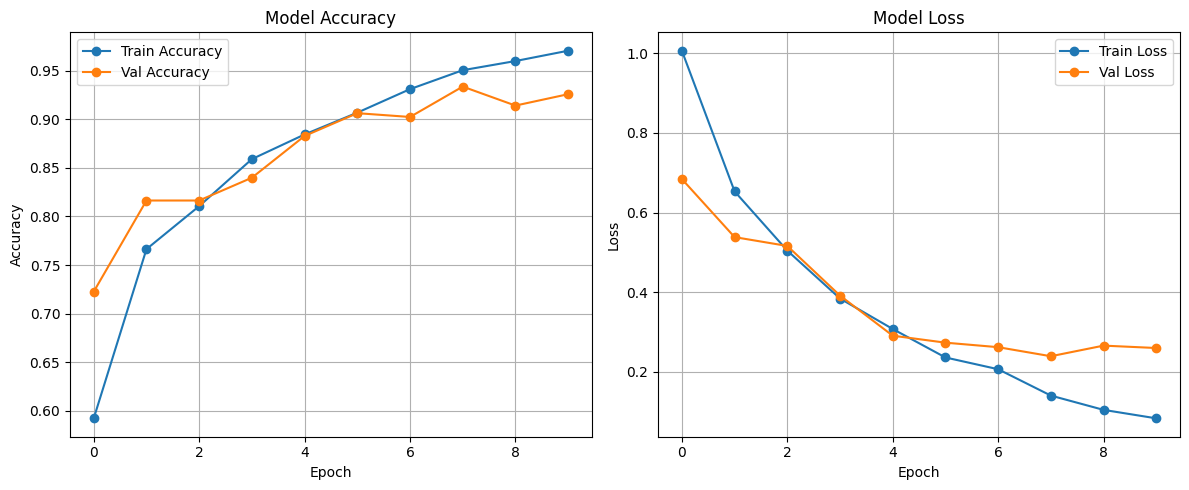

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Classification Report:

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98        90
  meningioma       0.87      0.84      0.85        63
    no_tumor       0.85      0.92      0.88        49
   pituitary       0.96      0.96      0.96        54

    accuracy                           0.93       256
   macro avg       0.92      0.92      0.92       256
weighted avg       0.93      0.93      0.93       256



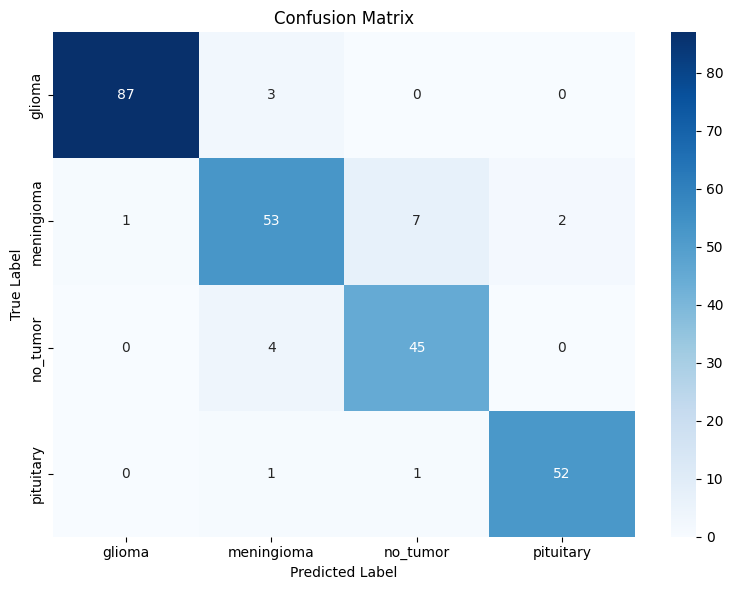

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get predictions from the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Step 2: Print Classification Report
target_names = le.classes_
report = classification_report(y_true, y_pred, target_names=target_names)
print("Classification Report:\n")
print(report)

# Step 3: Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names,
            yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


###Download model

In [22]:
model.save("brain_tumor_model.keras")  # or .h5

In [23]:
import pickle

class_names = ['glioma', 'meningioma', 'no_tumor', 'pituitary']
with open("class_names.pkl", "wb") as f:
    pickle.dump(class_names, f)
